<h1><font color="#113D68" size=5>Módulo 6</font></h1>



<h1><font color="#113D68" size=6>Capstone: Análisis de un problema de clasificación</font></h1>

<br><br>
<div style="text-align: right">
  <font color="#113D68" size=3>Daniel González y Fernándo Rubio</font><br>
  <font color="#113D68" size=3>Máster en Ciencia de Datos e Ingienería de Datos en la Nube</font><br>
  <font color="#113D68" size=3>Universidad de Castilla-La Mancha</font>
</div>

In [1]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.metrics as confusion_matrix
from sklearn.model_selection import train_test_split

---


# Introducción

El objetivo del Capstone es **simular un análisis completo de un problema de clasificación de imágenes usando Deep Learning**.

El análisis está compuesto de una serie de pasos que iremos viendo detenidamente uno por uno, que os puede servir de guía para seguir a la hora de resolver un problema con Deep Learning. Los **pasos** que vamos a seguir son los siguientes:

1. **Dataset**: Descarga y previsualización de los datos.
2. **Preprocesamiento de los datos**: prepararemos las imágenes para que puedan ser entrenadas.
3. **Modelo desde cero**: Creación de una red neuronal desde cero.
4. **Ajuste de hiperparámetros**: Mejora del modelo anterior mediante el ajuste de hiperparámetros.
5. **Modelos pre-entrenados (fine-tunning)**: Uso de técnicas de *Finetunning* sobre un modelo pre-entrenado.
6. **Data augmentation (Opcional)**: Uso de *data augmentation* en el dataset.
7. **Conclusión**: se deberá sacar unas conclusiones a partir de los resultados obtenidos, decidiendo cual de los modelos entrenados podríamos desplegar en producción para usarlo.

Los puntos a completar son del 3 al 7, en **cada punto se detalla exactamente qué se tiene que hacer**, es decir, habrá bloques de código en blanco y se detallará las arquitectura de las redes y la configuración de los entrenamientos, por lo que las redes a crear serán las indicadas en cada paso.

Al final de cada paso habrá que comentar los resultados obtendos en los entrenamientos, sacando **conclusiones de los experimentos** que vamos a llevar acabo, justificando y midiendo el rendimiento de los modelos obtenidos según las técnicas que utilicemos. La evaluación de los modelos se realizará en terminos de tasa de aciertos y la matriz de confusión de las clases.

_**Nota**: ejecuta el siguiente código para montar tu Drive y no perder los datos que vayamos a descargar. Además se hará un `cd` hacia el drive para guardar ahí todos los datos generados y descargados_

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


---

# Dataset

El dataset utilizado está compuesto por imágenes de distintas razas de perro. El dataset contiene 12.891 imágenes con 74 razas, por lo tanto, el objetivo será crear y entrenar un módelo que clasifique la raza de un perro a partir de una imagen. Para descargar el dataset ejecuta la siguiente celda:

In [4]:
!wget 'https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1'
!mv 'ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1' dog-images.zip
!unzip -q dog-images.zip

--2024-02-28 20:37:18--  https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1
Resolving pruebasaluuclm-my.sharepoint.com (pruebasaluuclm-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to pruebasaluuclm-my.sharepoint.com (pruebasaluuclm-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/fernando_rubio_uclm_es/Documents/dog-dataset.zip?ga=1 [following]
--2024-02-28 20:37:18--  https://pruebasaluuclm-my.sharepoint.com/personal/fernando_rubio_uclm_es/Documents/dog-dataset.zip?ga=1
Reusing existing connection to pruebasaluuclm-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 498626796 (476M) [application/x-zip-compressed]
Saving to: ‘ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1’

ESpljekZA9dAgxsfc3q 100%[===================>] 475.53M  54.4MB/s    in 13s     



Se descargará un archivo `dog-images.zip` que se descomprimirá automáticamente creando la carpeta `dog-dataset` que contiene el dataset completo. La estructura de los ficheros descargados sera:

```
--> dog-images.zip
--> dog-dataset/
-->    test.csv
-->    train.csv
-->    valid.csv
-->    dog-images/
-->        Afghan_hound/
-->        African_hunting_dog/
-->        ...
```


En el interior de la carpeta `dog-dataset` se encuentrarn 3 ficheros *CSVs* y otra carpeta (`dog-images`):

* Carpeta `dog-images`: contiene todas las imágenes del dataset. Las imágenes están distribuidas por carpetas según las disintas razas (74 carpetas en total). El nombre de cada carpeta corresponde con la raza.
* `train.csv`: conjunto de datos para el entrenamiento, 8.992 imágenes. El fichero está en formato *CSV* y cada fila se corresponde con una imagen distinta. El *CSV* tiene 2 columnas, la columna *label* que corresponde a la clase (raza) y la columna *path* que correponde con la ruta donde está cada imagen en la carpeta `dog-images`.
* `valid.csv`: conjunto de datos para la validación, 1.894 imágenes. Mismo formato que `train.csv`.
* `test.csv`: conjunto de datos para el test, 2.005 imágenes. Mismo formato que `train.csv`.

A continuación se muestran varias imágenes del dataset.

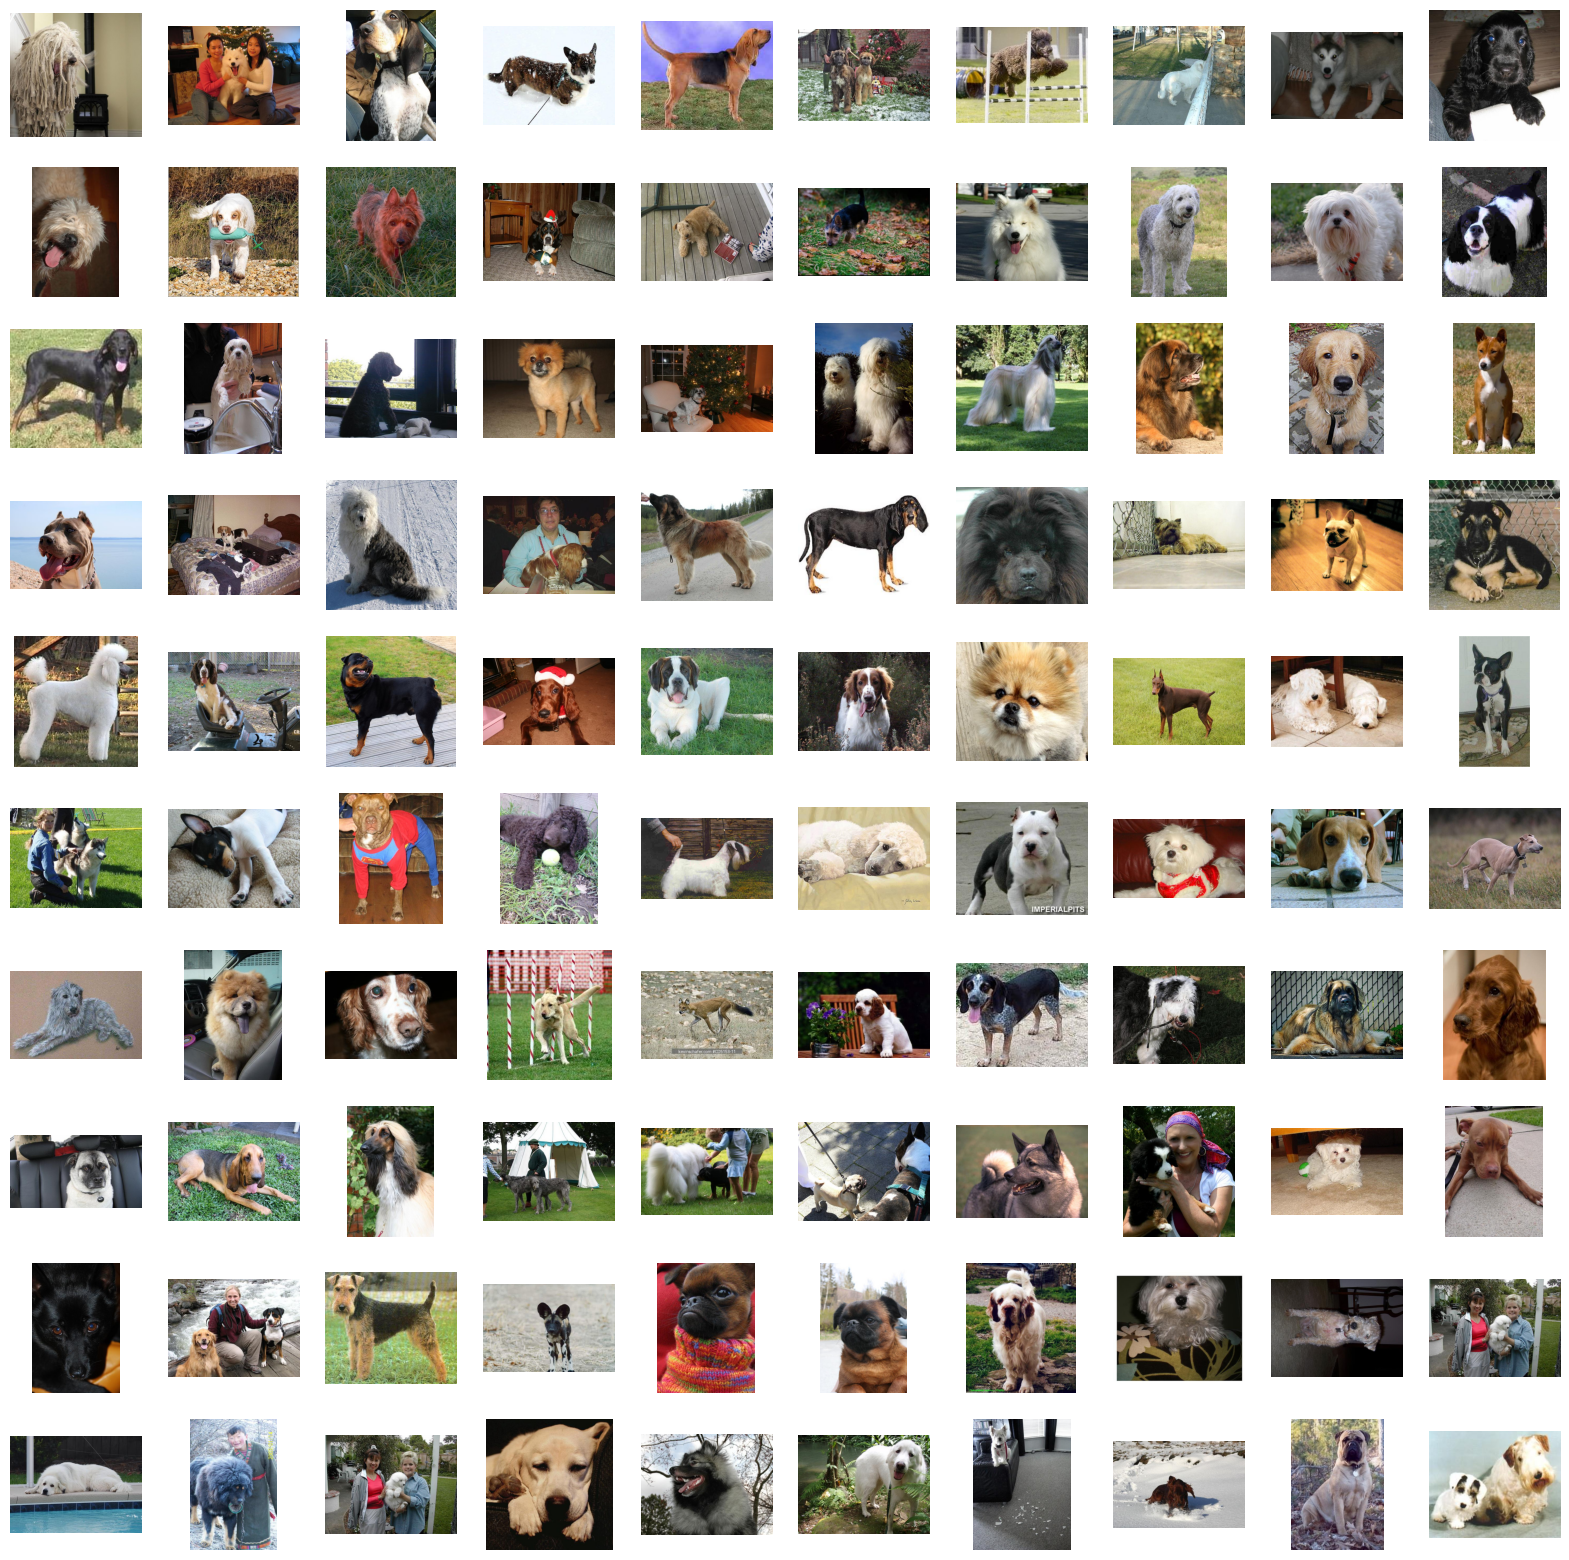

In [5]:
def show_images(img_paths):
    fig=plt.figure(figsize=(20, 20))
    index = np.random.randint(len(img_paths), size=100)
    for i in range(100):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        img = Image.open(img_paths[index[i]])
        plt.imshow(img)
    plt.show()

files = [f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)]
show_images(files)

Podemos obserar las siguientes características que pueden complicar el problema:

- Las imágenes son de **diferentes tamaños**.
- Hay **diferentes objetos en las imágenes**.

Vamos a crear un lista (`classes`) con el nombre de las razas de los perros que serán las clases en las que clasificarán los modelos que creemos:

In [6]:
classes = [f.split('/')[-1] for f in glob.glob("dog-dataset/dog-images/**")]
classes

['Australian_terrier',
 'Great_Pyrenees',
 'Maltese_dog',
 'whippet',
 'Boston_bull',
 'Irish_setter',
 'Rottweiler',
 'schipperke',
 'Leonberg',
 'Welsh_springer_spaniel',
 'Pomeranian',
 'Pekinese',
 'Irish_wolfhound',
 'Blenheim_spaniel',
 'basenji',
 'African_hunting_dog',
 'komondor',
 'Yorkshire_terrier',
 'Japanese_spaniel',
 'dhole',
 'Lhasa',
 'Walker_hound',
 'standard_poodle',
 'Saint_Bernard',
 'Afghan_hound',
 'Newfoundland',
 'black-and-tan_coonhound',
 'pug',
 'Scottish_deerhound',
 'cairn',
 'malamute',
 'beagle',
 'West_Highland_white_terrier',
 'Brittany_spaniel',
 'English_springer',
 'Doberman',
 'Pembroke',
 'Norwegian_elkhound',
 'Sussex_spaniel',
 'soft-coated_wheaten_terrier',
 'cocker_spaniel',
 'American_Staffordshire_terrier',
 'Samoyed',
 'Brabancon_griffon',
 'groenendael',
 'Shetland_sheepdog',
 'Lakeland_terrier',
 'miniature_poodle',
 'golden_retriever',
 'borzoi',
 'chow',
 'otterhound',
 'keeshond',
 'French_bulldog',
 'toy_terrier',
 'Sealyham_terrier

Vamos a mostrar una imagen aleatoria por cada clase:

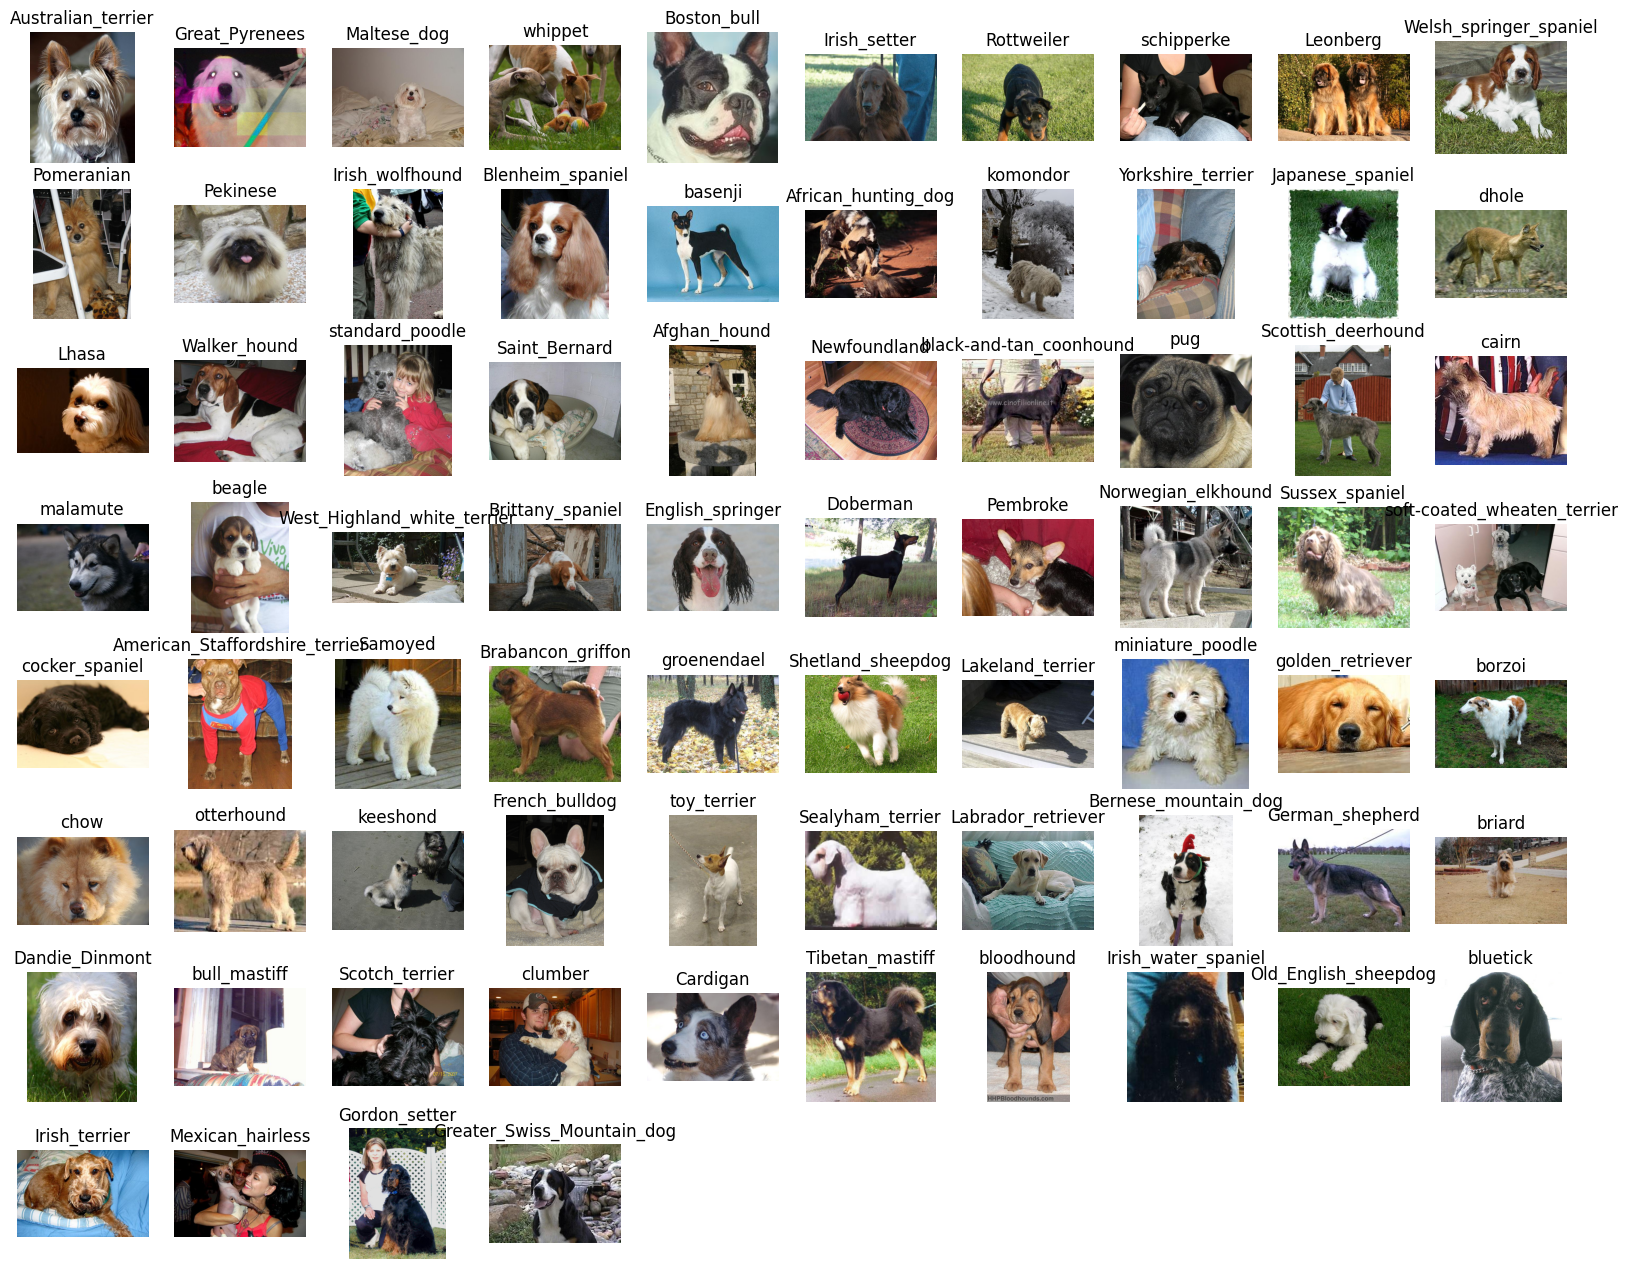

In [7]:
img_per_class = {}

for c in classes:
   files = [f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]
   index = np.random.randint(len(files))
   img_per_class[c] = files[index]

fig=plt.figure(figsize=(20, 20))
for i, (k, v) in enumerate(img_per_class.items()):
    fig.add_subplot(10, 10, i+1)
    plt.axis('off')
    img = Image.open(v)
    plt.title(k);
    plt.imshow(img)
plt.show()

Veamos si las clases están balanceadas:

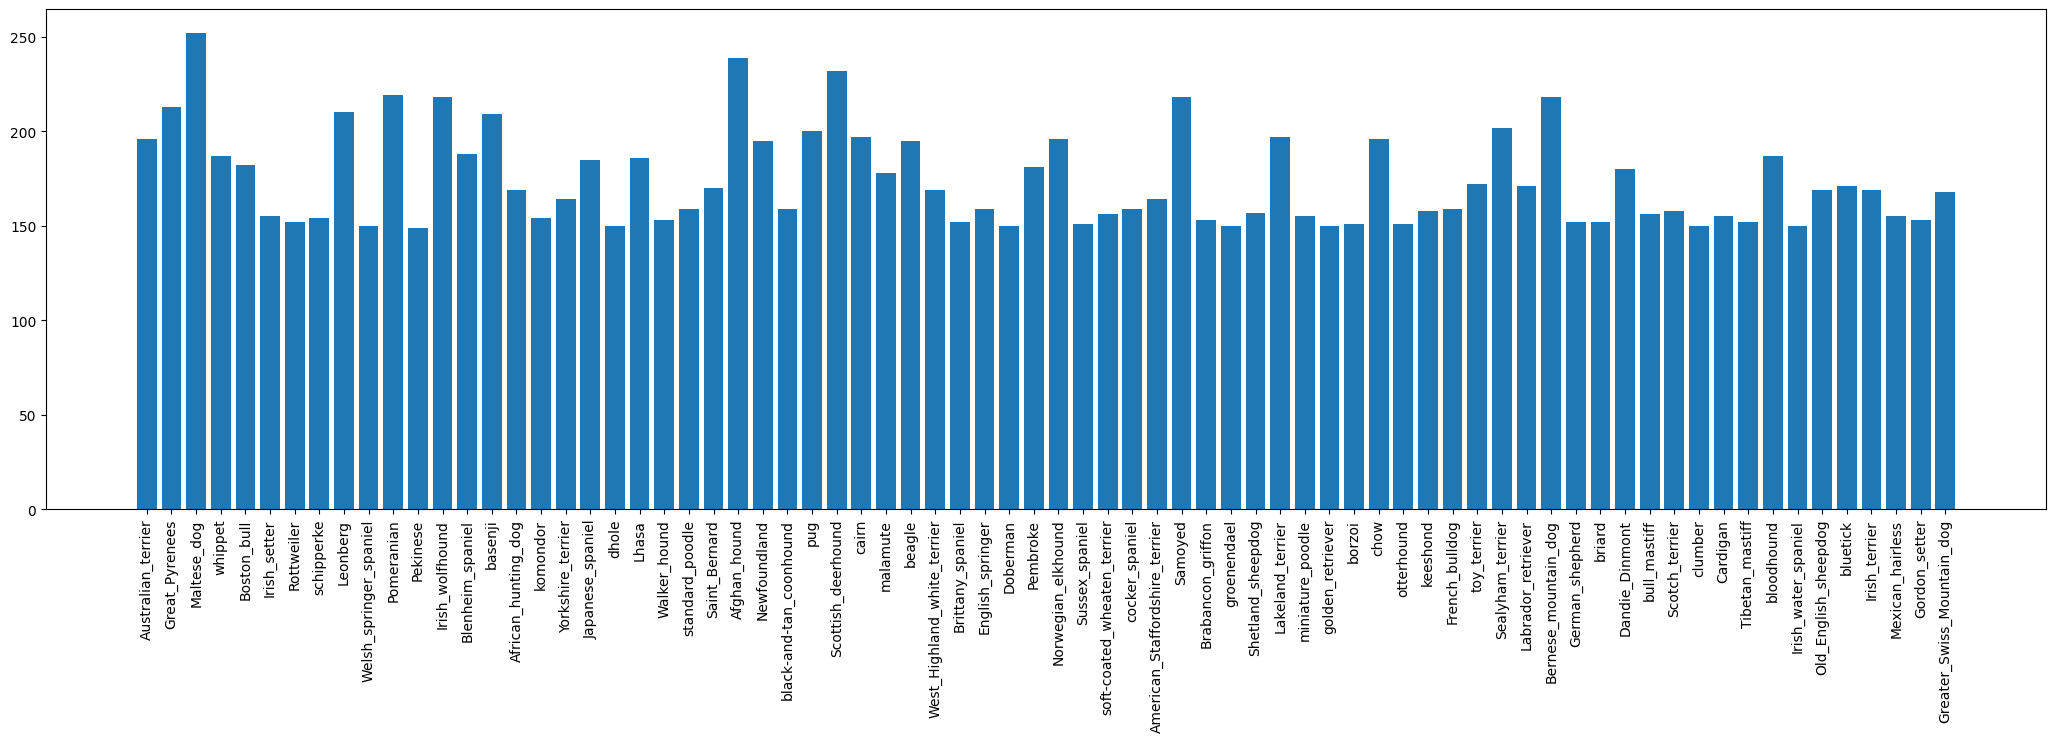

In [8]:
targets = [len([f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]) for c in classes]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,targets)
plt.xticks(rotation='vertical')
plt.show()

---

# Prepocesamiento de los datos



En esta sección vamos a cargar los datos creando los dataset para el conjunto de training, de validación y de test. En otras prácticas hemos visto como cargar con `tf.keras.utils.Sequence` batches de imágenes, sin embargo, se trata de una herramienta que aun está en desarrollo y que hay que entender la forma que tiene de trabajar `tensorflow` para hacer que funcione de forma óptima.

En este Capstone os vamos a dar una serie de funciones que permiten ejecutar los experimentos de forma más rápida para que no os tengáis que preocupar por la configuración de la base de datos.

In [ ]:
def read_image(image_path, label):
    """
      Cargamos una imagen usando su ruta (path), la convertimos en tensor y la normalizamos
    """
    contents = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(contents, channels=3)
    img = tf.cast(img, tf.float64)
    img /= 255.0
    return img, label

def resize_image(img, label, target_size):
    """
      Redimensionamos una imagen
    """
    resized_img = tf.image.resize(img, target_size)
    return resized_img, label

def get_dataset(image_paths, image_labels, target_size, batch_size, prep_func=None):
    """
      - Generamos un objeto tf.data.Dataset para optimizar el entrenamiento desde los
        paths de las imagenes
      - Aplicamos las funciones read_image y resize_image a las imagenes
      - Podemos usar una función prep_func si queremos hacer fine-tunning
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(read_image)
    dataset = dataset.map(lambda x, y: resize_image(x, y, target_size))

    if prep_func != None:
        dataset = dataset.map(lambda x, y: (x*255.0, y))
        dataset = dataset.map(lambda x, y: (prep_func(x), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

Con estas funciones, podemos crear unos `tf.data.Dataset` que son óptimos a la hora de leer imágenes en memoria y ejecutar los batches y la forma de crearlos y ejecutarlos es la siguiente:

```python
# definimos el img_size objetivo y el batch_size
img_size = (224,224,3)
batch_size = 32

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(images_train_paths, labels_train, img_size[0:-1], batch_size)

# ya solo nos queda llamar a fit con la base de datos
model.fit(train_dataset, epochs=10)
```

Así es como deberemos llamar al método en celdas sucesivas cuando queramos entrenar nuestras redes.

Aunque tenemos los csv con los conjuntos de `train`, `valid` y `test`, vamos generar las particiones nosotros mismos para ver cómo se hace y para asegurarnos que lo hacemos de forma correcta.


In [ ]:
num_to_label = {i: c for i, c in enumerate(classes)}
label_to_num = {c: i for i, c in enumerate(classes)}
image_paths = np.array([f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])
image_labels =  np.array([label_to_num[f.split('/')[-2]] for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])

In [ ]:
shuffler = np.random.permutation(len(image_paths))
image_paths = image_paths[shuffler]
image_labels = image_labels[shuffler]

# Train/valid/test split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(image_paths, image_labels, test_size=0.1, random_state=1234, stratify=image_labels)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=5678, stratify=y_train_valid)

print("Train: ", x_train.shape)
print("Valid: ", x_valid.shape)
print("Test: ", x_test.shape)

del x_train_valid, y_train_valid

Una vez tenemos listas las particiones, ya solo tenemos que crear los datasets con las funciones proporcionadas.

---

# Experimiento de ejemplo

Aquí os mostramos un ejemplo de experimento y evaluación de un modelo. Podéis basaros en este para los modelos que tenéis que crear vosotros.

# Arquitectura y configuración de la red

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa *Fully connected* con 1 neurona con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 2
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [ ]:
# Creamos nuestra red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="relu"),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.summary()

In [ ]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenamos
history = model.fit(train_dataset, epochs=2, validation_data=valid_dataset)

In [ ]:
# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

In [ ]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

In [ ]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

---

# Modelo desde cero

En esta sección se diseñará y entrenará una red convolucional siguiendo una estructura de tipo *VGG16* como las que vimos en clase. Una vez entrenada la red, tendrás que evaluar el resultado.

# Arquitectura y configuración de la red

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [ ]:
# COMPLETAR:
#   - Crear la red
#   - Entrena la red
#   - Evalúa la red

**COMPLETAR: saca conclusiones del resultado**

---

# Ajuste de hiperparámetros


En esta sección vamos a intentar mejorar la red anterior con capas `Dropout` y cambiando los hiperparámetros.

La arquitectura de la red es la siguiente:

* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa *Dropout* con valor 0.2.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [ ]:
# COMPLETAR:
#   - Crear la red
#   - Entrena la red
#   - Evalúa la red

**COMPLETAR: saca conclusiones del resultado**

---

# Modelos pre-entrenados (fine-tunning)

En esta sección tendréis que utilizar los conocimientos sobre los modelos pre-entrenados y _fine-tunning_, donde tendréis que adaptar una red pre-entrenada a nuestro problema. El modelo pre-entreando que tendréis que usar es _Inception_, cuya versión 3 es de las más utilizadas en _Fine-tuning_ por sus buenos resultados.

## Inception

La configuración de la red a cargar es la siguiente:

* Tamaño de entrada será `(299, 299, 3)`.
* Elegiremos la configuración `include_top = false` y el `pooling = 'avg'`
* Añadiremos una capa de _Dropout_ de 0.5
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Epochs: 10
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
# esta vez usams la fucnion de preprocesamiento de inception
img_size = (299,299,3)
batch_size = 128
epochs = 10

train_dataset = get_dataset(x_train, y_train, img_size[0:-1], batch_size,
                            tf.keras.applications.inception_v3.preprocess_input)

valid_dataset = get_dataset(x_valid, y_valid, img_size[0:-1], batch_size,
                            tf.keras.applications.inception_v3.preprocess_input)

test_dataset = get_dataset(x_test, y_test, img_size[0:-1], batch_size,
                           tf.keras.applications.inception_v3.preprocess_input)

In [ ]:
# COMPLETAR:
#   - Crear la red
#   - Entrena la red
#   - Evalúa la red

**COMPLETAR: saca conclusiones del resultado**

---

# Data augmentation (Opcional)

En este apartado se deberán aplicar algunas de las funciones de preprocesamiento vistas en la clase de _data augmentation_. Nos centraremos en *data augmentation* estocástico sobre la red obtenida en el apartado de modelos desde 0 y tratar de mejorar el rendimiento. Vamos a utilizar una o varias de las siguientes modificaciones:

  *    Flip horizontal
  *    Flip vertical
  *    Contraste

# Arquitectura y configuración de la red

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128





In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
batch_size = 128

train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size)

In [ ]:
# COMPLETAR:
#   - Crear la red
#   - Entrena la red
#   - Evalúa la red

**COMPLETAR: saca conclusiones del resultado**

# Conclusión
Una vez realizado todos los experimentos anteriores, ¿qué modelo elegirías para desplegar en producción? ¿Por qué?

Explica en breves palabras qué modelo eligirías para desplegar en producción y porqué. Compara cada experimento y extráis tus propias conclusiones.

**COMPLETAR: saca conclusiones de todos los experimentos anteriores**

<div style="text-align: center; font-size: 24px;">
    <img src="https://drive.google.com/uc?id=1xHx0M9NUXi4YcDyi1BwuUE6y0TK0kHfs">
</div>

###  ¡Si has llegado hasta aquí deberías estar super orgullos@!
###  Ya puedes relajar tus neuronas, les has dado mucho trabajo